### Processes images generated from Minecraft screen captures into an HDF5 dataset file

#### Current dataset format

Screenshots are created by teleporting to 3 different world locations:
- **farm**: (-50, 64, 410)
- **forest**: (-273, 65, 782)
- **home**: (-105, 63, 59)

At each location, the pitch is varied to cause the bot to rotate slowly in a circle, and the yaw is chosen randomly at each time step from the interval (-0.20, 0.20) in radians.

The dataset file that is produced by this notebook is in HDF5 format and contains a total of **3600** images. There are **1200** images from each location, and the images are grouped by location in the following order: **farm, forest, home**. Inside each group, the images are shuffled to remove temporal correlations. Each image is a matrix of shape **(1050, 1680, 3)**.

In [113]:
from scipy import ndimage
from scipy.misc import imresize
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Example: loading a PNG image

In [114]:
file = "/Users/cosmo/Documents/workspace/screenshot/farm/7.png"
image = ndimage.imread(file)

Check the dimension of the screenshots:

In [115]:
image.shape

(1050, 1680, 3)

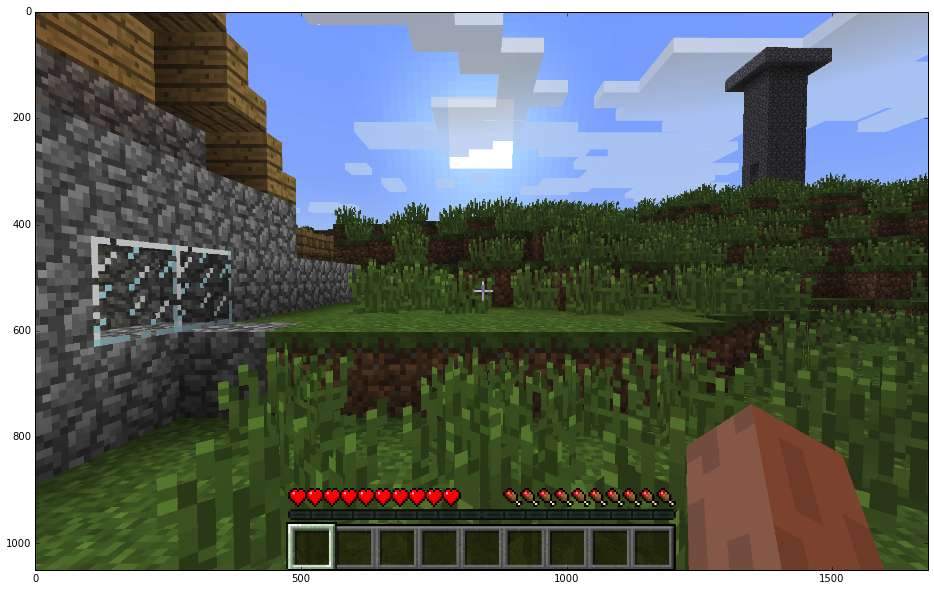

In [116]:
plt.figure(figsize = (16, 10))
plt.imshow(image);

### Load all of the image files from the screen captures generated in different world regions

In [122]:
import glob

In [131]:
farm_files = glob.glob('/Users/cosmo/Documents/workspace/screenshot/farm/*.png')
forest_files = glob.glob('/Users/cosmo/Documents/workspace/screenshot/forest/*.png')
home_files = glob.glob('/Users/cosmo/Documents/workspace/screenshot/home/*.png')

#### Shuffle the order of the images to remove the temporal correlation

In [133]:
np.random.shuffle(farm_files)
np.random.shuffle(forest_files)
np.random.shuffle(home_files)

#### Downsampling the images is possible:

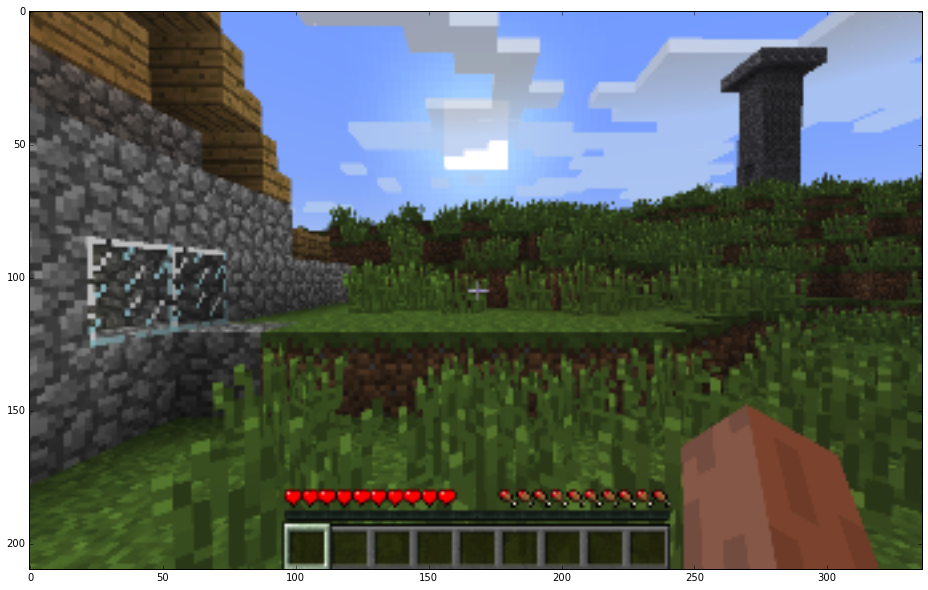

In [10]:
scale = 5
plt.figure(figsize = (16, 10));
plt.imshow(imresize(image, (1050/scale, 1680/scale)));

If we don't downsample, we have $1680*1050=1764000$ pixels per image. If we downsample by a factor of 5, then we have $336*210=70560$ pixels per image.

## Create the HDF5 dataset

In [104]:
import h5py
from fuel.datasets.hdf5 import H5PYDataset

In [105]:
f = h5py.File('dataset.hdf5', mode='w')

In [106]:
num_images = 1200 * 3
height = 1050
width = 1680
colors = 3

In [107]:
vector_images = f.create_dataset('vector_images', (num_images, height, width, colors), dtype='uint8')

#### Load the images into the dataset

In [138]:
vector_images[...] =  np.vstack([[ndimage.imread(file) for file in farm_files],
                                 [ndimage.imread(file) for file in forest_files],
                                 [ndimage.imread(file) for file in home_files]])

#### Multiple datasets can be combined by using splits. In this case we only use 1.

In [139]:
split_dict = {
    'train': {'vector_images': (0, 4)},
}
f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

In [140]:
f.flush()
f.close()

### Access the HDF5 dataset we created

In [158]:
from fuel.datasets.hdf5 import H5PYDataset

In [159]:
dataset = H5PYDataset('dataset.hdf5', which_set=('train'))

In [161]:
handle = dataset.open()

#### Load a small slice from each subset of the data and look at the resulting images

In [176]:
offset = 1200
farm_data_slice,   = dataset.get_data(handle, slice(0, 5))
forest_data_slice, = dataset.get_data(handle, slice(1 * offset + 1, 1 * offset + 1 + 5))
home_data_slice,   = dataset.get_data(handle, slice(2 * offset + 1, 2 * offset + 1 + 5))

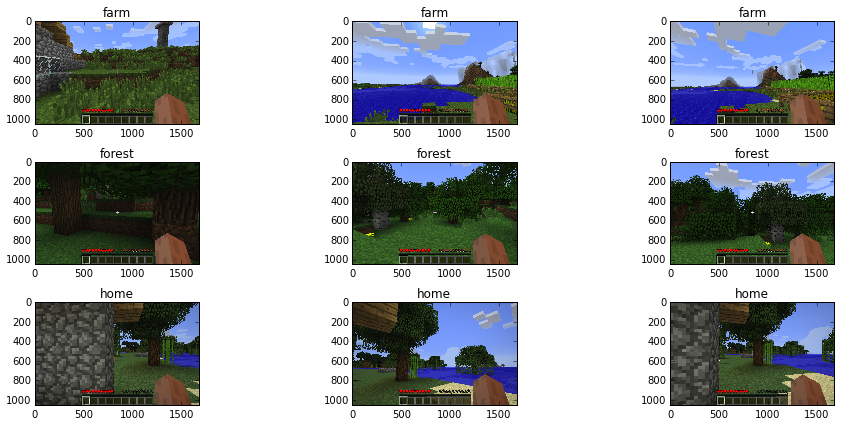

In [216]:
fig = plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k');
data_sources = [farm_data_slice, forest_data_slice, home_data_slice]
titles = ['farm', 'forest', 'home']
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(3,3,i*3+j+1);
        ax.imshow(data_sources[i][j]);
        ax.set_title(titles[i]);
fig.tight_layout();

In [147]:
dataset.close(handle)